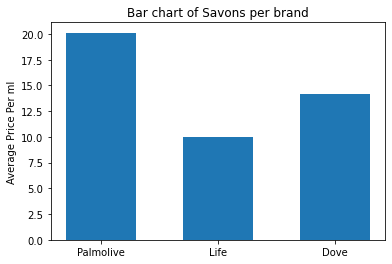

In [9]:
import urllib.request
import re
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import urllib
from datetime import datetime , date
import time
import random
from sqlalchemy import create_engine, Table, MetaData, Column, Integer, String, Float,DateTime,Date
from sqlalchemy import select, desc,exists,and_
from sqlalchemy.sql import func 
import matplotlib.pyplot as plt
import os

#Connect DB
pathDB = '\\'.join(os.path.abspath(os.getcwd()).split('\\')[:-1])+'\\Data Bases'
engine = create_engine('sqlite:///'+pathDB+'\\superpharmDB5.db', echo=False,connect_args={'timeout': 100})
metadata = MetaData()
conn1 = engine.connect()

brandname_dict = {'אולטרסול':'Ultrasol',
                 'קוסמטיקה':'Cosmetics',
                 'טיפוח':'Care',
                 'לבית' : 'Home',
                 'אופטיקה' : 'Optic',
                 'סקין גארד':'Skin Guard',
                 'ג\'ילט' : 'Gilette',
                 'ויט' : 'Veet',
                 'דאב' : 'Dove',
                 'אולוויז' : 'Always',
                 'סאנדיי' :'Sunday',
                 'Ray-Ban *יבוא מקביל' :'Ray-Ban', 
                 'SHISEIDO':'Shiseido',
                 'ACUVUE':'Acuvue',
                 'נטורל פורמולה' :'Natural Formula',
                 'לבלו':'Labello'}


categoryname_dict = {'שמפו ומרכך' : 'Shampoo & Conditionner',
                  'סבונים ומוצרי רחצה' : 'Soaps and bath products',
                  'הסרת שיער' : 'Hair Removal',
                  'אביזרי גילוח' : 'Shaving Accessories',
                  'הגנה מהשמש': 'Sun Protection',
                  'קרמי ידיים וגוף' : 'Hand creams and body',
                  'דאודורנטים' : 'Deodorants',
                  'היגיינת הפה' : 'Oral hygiene',    
                  'טיפוח מהטבע' : 'Cultivation from Nature',
                  'טיפוח פנים' : 'Face Care',
                   'היגיינה אינטימית' : 'Intimate Hygiene'}



# df = pd.read_sql_query("SELECT * FROM items", conn1)

df = pd.read_sql_query("SELECT id,name,description,category,brand,department,"\
                       "amount,date FROM items i "\
                       "INNER JOIN prices p ON i.id=p.item_id "\
                       "WHERE date !=date(\'now\')", conn1)

df = df.set_index('id')

savons = df[(df.name.str.contains('ג\'ל רחצה') | df.name.str.contains('סבון') | df.name.str.contains('תחליב'))]
savons = savons[savons.category == 'סבונים ומוצרי רחצה']

savons.loc[savons.description.str.contains('750'), 'perMl'] = savons.amount / 750 
savons.loc[savons.description.str.contains('500'), 'perMl'] = savons.amount / 500 
savons.loc[savons.description.str.contains('700'), 'perMl'] = savons.amount / 700 
savons.loc[savons.description.str.contains('650'), 'perMl'] = savons.amount / 650 

pal = savons[savons.brand == 'פלמוליב'].amount.mean()
life = savons[savons.brand == 'Life'].amount.mean()
dove = savons[savons.brand == 'דאב'].amount.mean()


fig = plt.figure()
ax = fig.gca()
ax.bar(x=list(range(3)), 
       width=0.6,
       height=[pal,life, dove],
       align='center',
       tick_label=['Palmolive','Life','Dove'])
ax.set_title('Bar chart of Savons per brand')
ax.set_ylabel('Average Price Per ml')
plt.show()


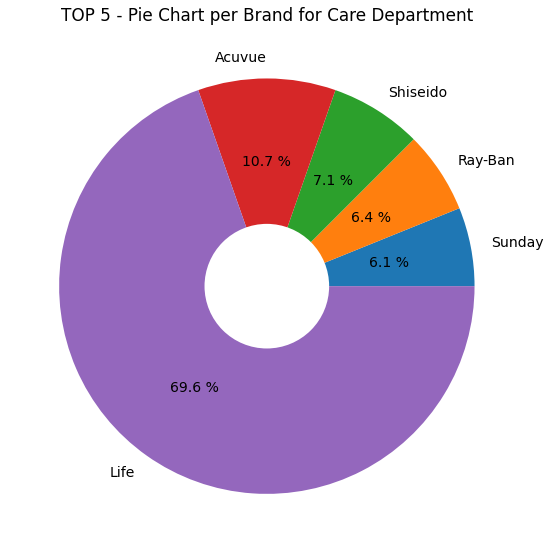

In [10]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
result = df.groupby(['brand']).count()
result = result.sort_values(by='name').tail(5)
result = result.reset_index()

result = result.replace({'brand': brandname_dict})
result = result.set_index("brand")

fig = plt.figure(figsize=(45,8))
centre_circle = plt.Circle((0,0),0.30,fc='white')
ax = fig.gca()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

ax.set_title('TOP 5 - Pie Chart per Brand for Care Department')
ax.pie(list(result.name), labels=list(result.index),autopct='%.1f %%',labeldistance=1.1)
plt.show()




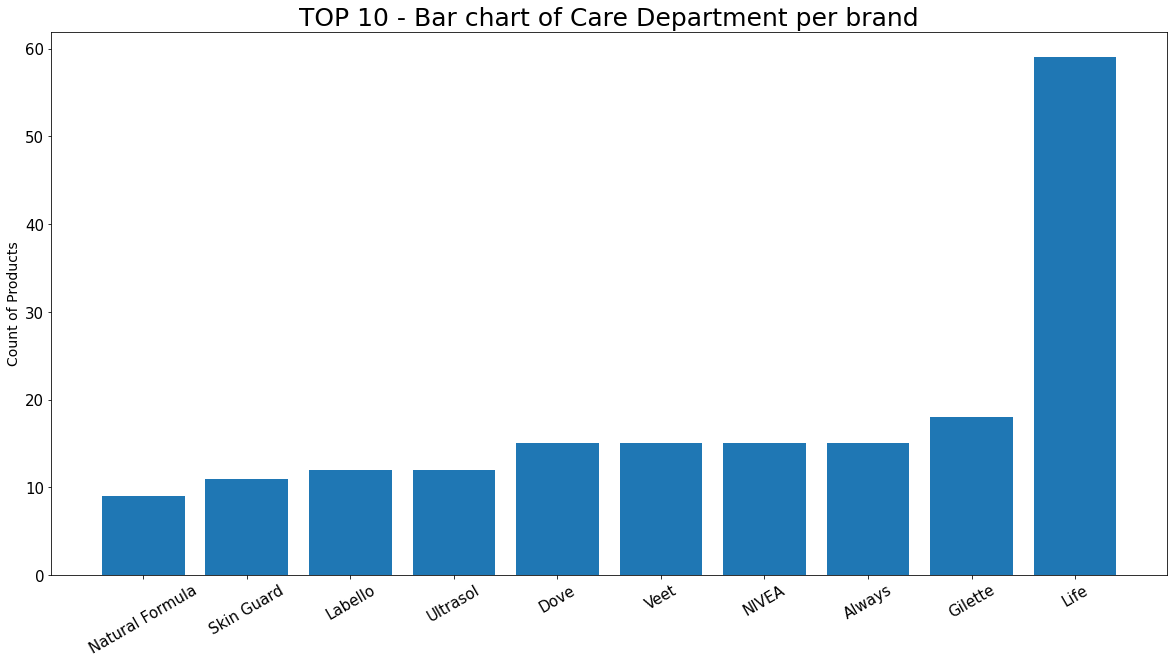

In [11]:
care_df = df[df.department == "טיפוח"]
result = care_df.groupby(['brand']).count()
result = result.sort_values(by='name').tail(10)
result = result.reset_index()
result = result.replace({'brand': brandname_dict})
result = result.set_index("brand")

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.bar(x=range(len(result.index)), \
       width=0.8,\
       height=list(result.name),\
       align='center',\
       tick_label=list(result.index))
ax.set_title('TOP 10 - Bar chart of Care Department per brand',fontsize=25)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
ax.set_ylabel('Count of Products')
plt.show()

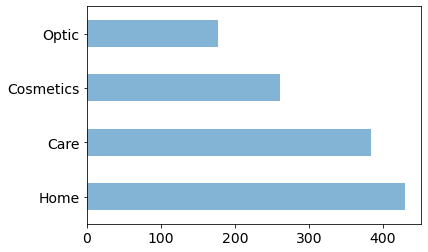

In [12]:
alpha_bar_chart = 0.55
result = df.replace({'department': brandname_dict})
result.department.value_counts().plot(kind='barh', alpha=alpha_bar_chart)

In [632]:
#plots an axis lable
fig = plt.figure(figsize=(25,10), dpi=1600)
ax1=fig.add_subplot(221)
# plots a kernel density estimate of the subset of the department amount
result.amount[result.department == 'Home'].plot(kind='kde') 
result.amount[result.department == 'Care'].plot(kind='kde')
result.amount[result.department == 'Optic'].plot(kind='kde') 
plt.legend(('Home', 'Care','Optic'),loc='best') 
ax1.set_xlim(-500, 500)
ax1.set_title('Distribution of Prices by Department')


alpha_level = 0.65
ax2=fig.add_subplot(223)
result = df.replace({'department': brandname_dict , 'category' : categoryname_dict})
categories_count = result[result.department == 'Care'].category.value_counts()
cat_up30 = categories_count[categories_count > 29].index
for c in cat_up30:
    result.amount[result.category == c].plot(kind='kde') 
    
ax2.set_xlim(-50, 50)
ax2.set_title('Distribution of Prices in Care Department by Category')
plt.legend((cat_up30),loc='best') 

In [633]:
dfnew = pd.read_sql_query("SELECT id,name,description,category,brand,department,"\
                       "amount,date,update_date FROM items i "\
                       "INNER JOIN prices p ON i.id=p.item_id", conn1)

In [634]:
dfnew[['id','amount']].sort_values(by='id')
dfnew3 = dfnew[['id','amount']]
#Simulate price change
dfnew3.at[2494, 'amount'] = 169.9
#Find Changed Prices
dfnew3[dfnew3.groupby("id")["amount"].pct_change(1) > 0]

id  amount
2494  400782   169.9

In [14]:
from googletrans import Translator
translator = Translator()

brands_name = list(df.brand.unique())
categories_name = list(df.category.unique())
products_name = list(df.name.unique())
dep_name = list(df.department.unique())
desc_name = list(df.description.unique())

result = brands_name + categories_name + products_name + dep_name + desc_name
mydict = {mydict[name] = translator.translate(name).text for name in result}